In [2]:
infrastructures = {
  'education': [
    {
      'ru_name': 'Детские сады',
      'name':'kindergarten',
      'tags': {'amenity':'kindergarten'}
    }, 
    {

      'name':'school',
      'tags':{'amenity':'school'}
    },
    {
      'name':'university',
      'tags':{'amenity':'university'}
    }
  ],
  'healthcare': [
    {
      'name':'polyclinic',
      'tags':{'amenity':'clinic'}
    }, 
    {
      'name':'pharmacy',
      'tags':{'amenity':'pharmacy'}
    }, 
    {
      'name':'hospital',
      'tags':{'amenity':'hospital'}
    }
  ],
  'leisure': [
    # {
    #   'name':'circus',
    #   'tags':{'theatre:genre':'circus'}
    # },
    {
      'name':'zoo',
      'tags':{'tourism':'zoo'}
    },
    {
      'name':'cinema',
      'tags':{'amenity':'cinema'}
    },
    {
      'name':'mall',
      'tags':{'shop':'mall'}
    },
  ],
  'culture': [
    {
      'name':'museum', 
      'tags':{'tourism':'museum'}
    }, 
    {
      'name':'theatre', 
      'tags':{'amenity':'theatre'}
    }
  ],
  'sport': [
    {
      'name':'pitch',
      'tags':{'leisure':'pitch'}
    },
    {
      'name':'swimming_pool',
      'tags':{'leisure':'swimming_pool'}
    }
  ],
  'tourism': [
    {
      'name':'hotel',
      'tags':{'tourism':'hotel'}
    },
    {
      'name':'hostel',
      'tags':{'tourism':'hostel'}
    }
  ],
}

In [7]:
local_crs = 32636

In [9]:
import geopandas as gpd

provisions = {service_type['name'] : gpd.read_file(f'data/provision/{service_type["name"]}_towns.geojson').to_crs(local_crs) for infrastructure in infrastructures.values() for service_type in infrastructure}

In [10]:
territories_names = ['lodey', 'shlis', 'siver', 'sveto']
territories = {}
for territory_name in territories_names:
  territories[territory_name] = gpd.read_file(f'data/territories/{territory_name}.geojson').to_crs(local_crs)

In [18]:
from townsnet.models.service_type import ServiceType
from townsnet.utils import SERVICE_TYPES

service_types = {}
for service_type in SERVICE_TYPES:
  service_types[service_type['name']] = ServiceType(**service_type)

In [114]:
import math

sjoins = {}

def accessibility_to_meters(time_min):
  return time_min * 283.33

for territory_name, territory_gdf in territories.items():
  sjoins[territory_name] = {}
  for service_type_name, provision_gdf in provisions.items():
    service_type = service_types[service_type_name]
    sjoin = provision_gdf.sjoin_nearest(territory_gdf[['geometry']], distance_col='distance')
    sjoins[territory_name][service_type_name] = sjoin.loc[sjoin['distance']<=accessibility_to_meters(service_type.accessibility)]

In [155]:
sjoins['sveto']['museum']

,id,name,okrug_name,rayon_name,demand,capacity,capacity_left,demand_left,demand_within,demand_without,provision,geometry,index_right,distance
1709,1709,Свободное,Каменногорское городское поселение,Выборгский муниципальный район,2.0,200.0,97.0,0.0,2.0,0.0,1.0,POINT (300272.536 6776676.341),0,15790.883735
1710,1710,Пруды,Каменногорское городское поселение,Выборгский муниципальный район,2.0,0.0,0.0,0.0,0.0,2.0,0.0,POINT (286282.234 6771649.161),0,10477.955755
1726,1726,Сосновая Горка,Каменногорское городское поселение,Выборгский муниципальный район,2.0,0.0,0.0,0.0,0.0,2.0,0.0,POINT (278503.545 6764966.257),0,16674.411766
1748,1748,Светогорск,Светогорское городское поселение,Выборгский муниципальный район,24.0,0.0,0.0,0.0,0.0,24.0,0.0,POINT (277202.153 6782386.154),0,2003.333149
1749,1749,Лесогорский,Светогорское городское поселение,Выборгский муниципальный район,24.0,0.0,0.0,0.0,0.0,24.0,0.0,POINT (279232.550 6779772.789),0,2306.205520
1750,1750,Лосево,Светогорское городское поселение,Выборгский муниципальный район,3.0,0.0,0.0,0.0,0.0,3.0,0.0,POINT (282044.655 6778720.434),0,2706.779313
1751,1751,Правдино,Светогорское городское поселение,Выборгский муниципальный район,3.0,0.0,0.0,0.0,0.0,3.0,0.0,POINT (276172.347 6772439.964),0,10249.305904


/home/vasilstar/townsnet/.venv/lib/python3.10/site-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/tmp/ipykernel_16104/2184781447.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10,10))


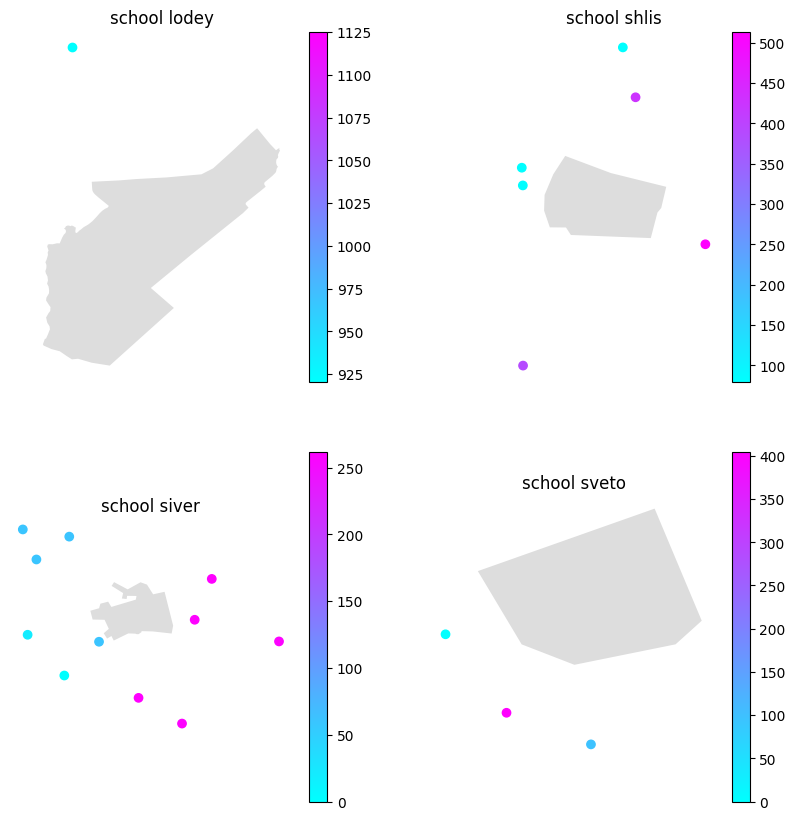

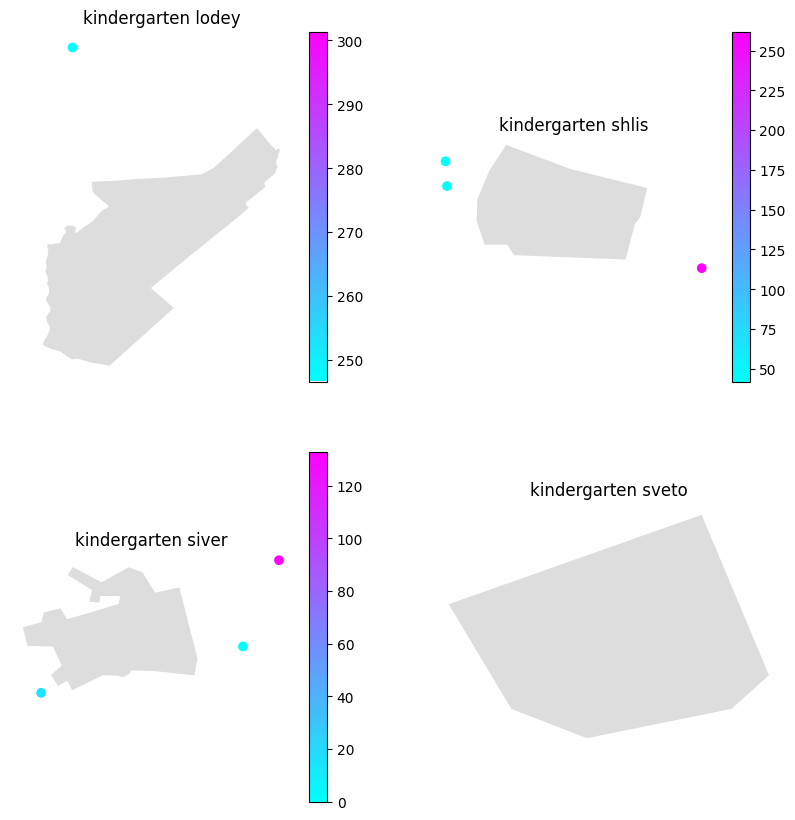

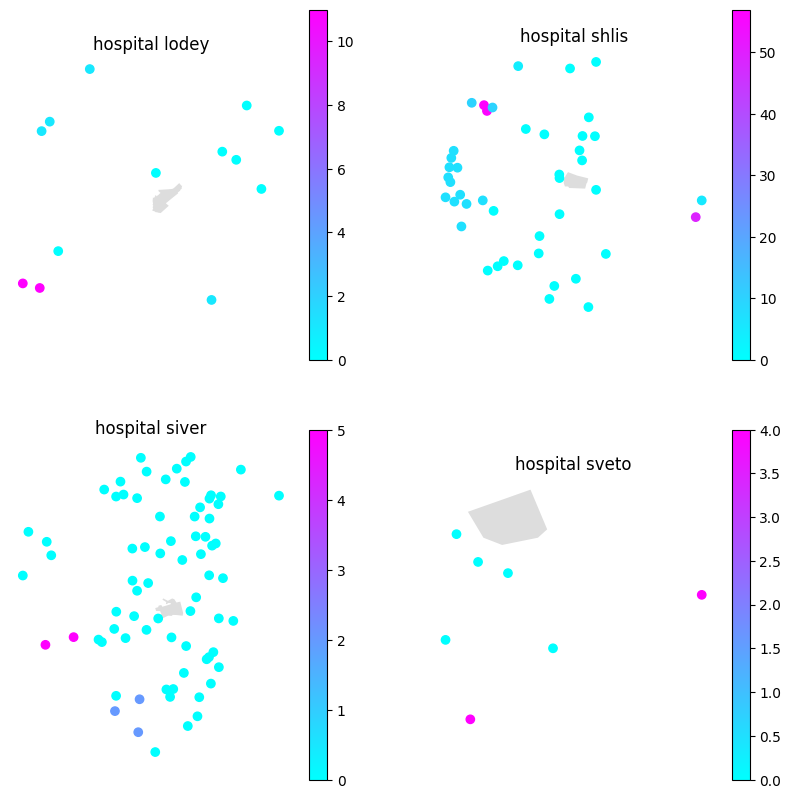

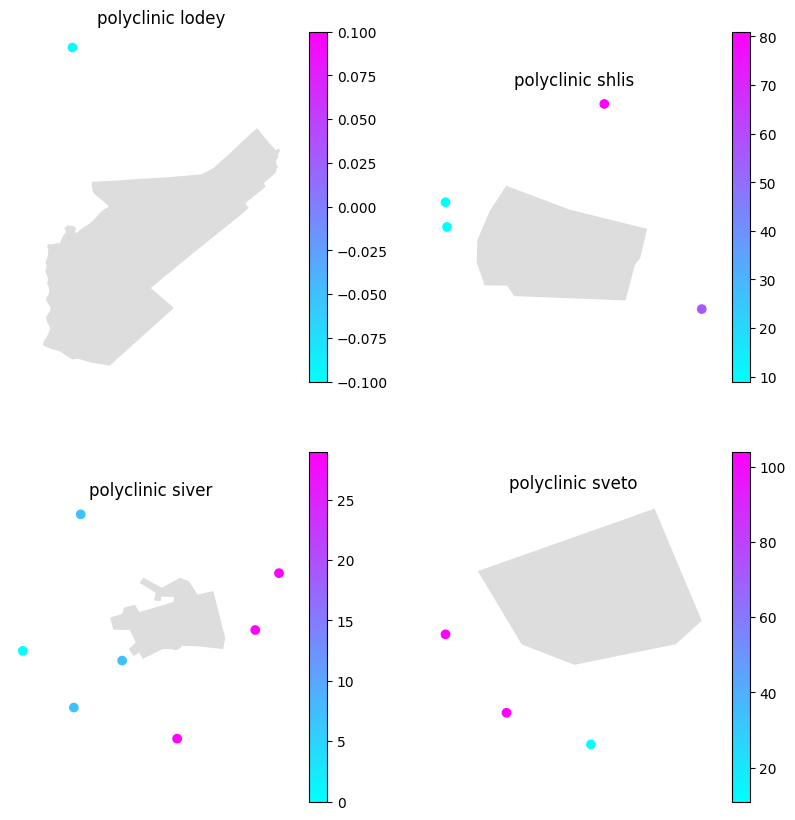

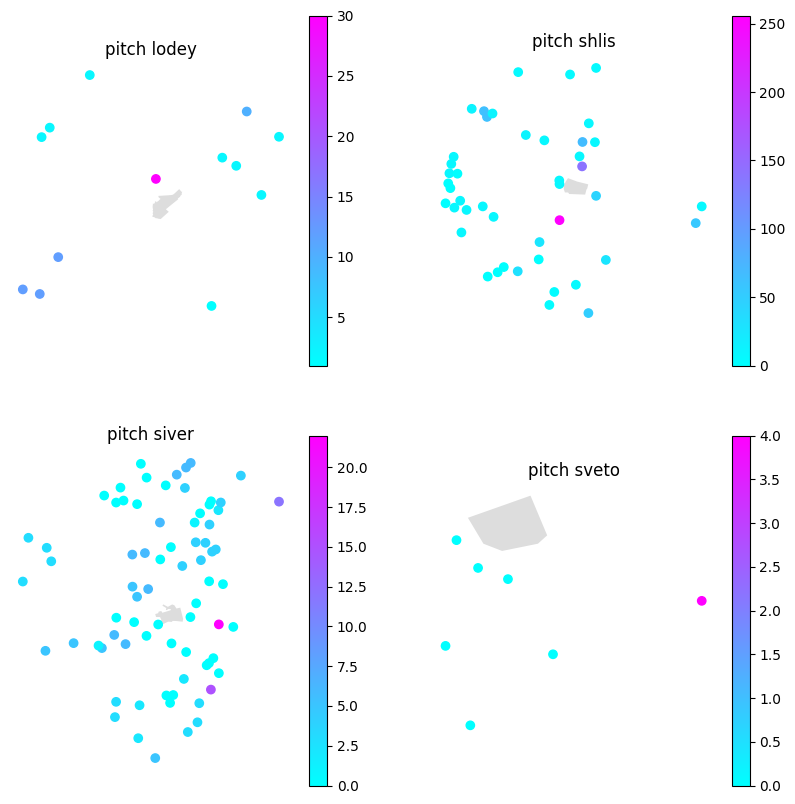

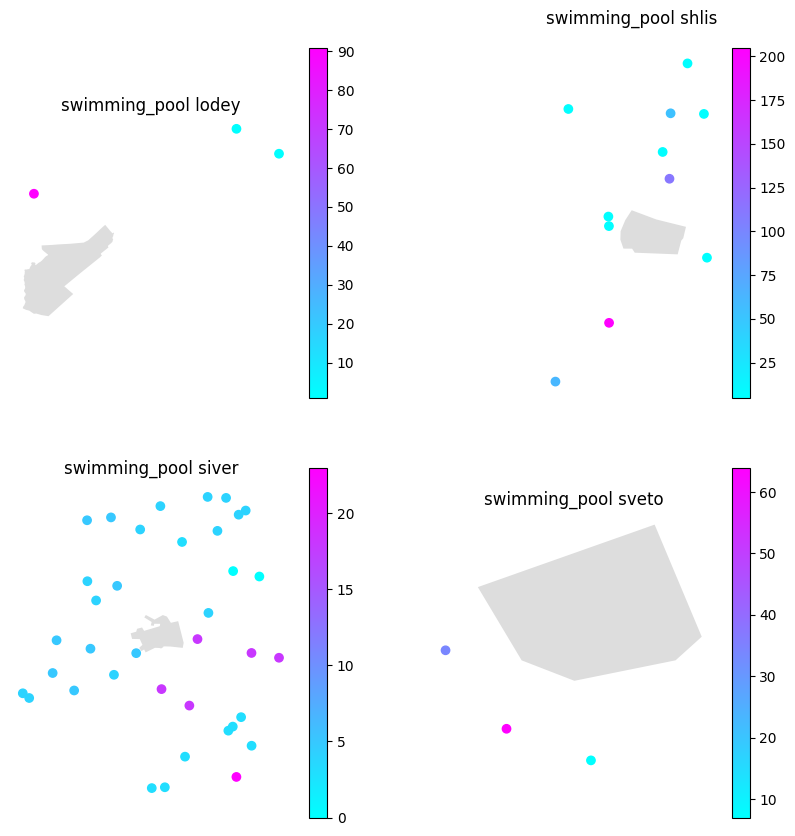

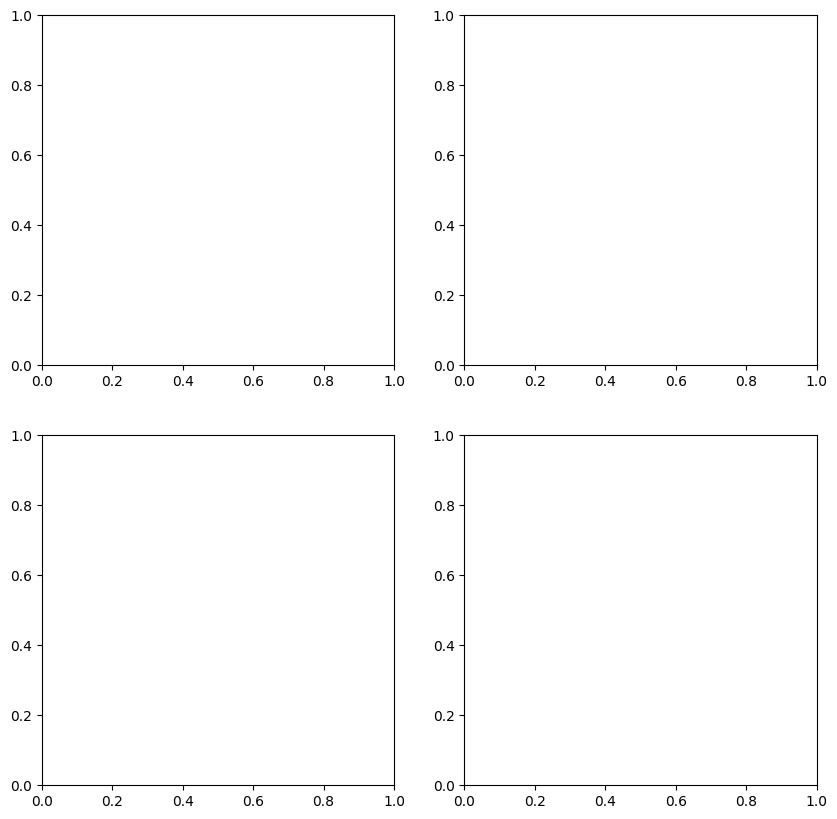

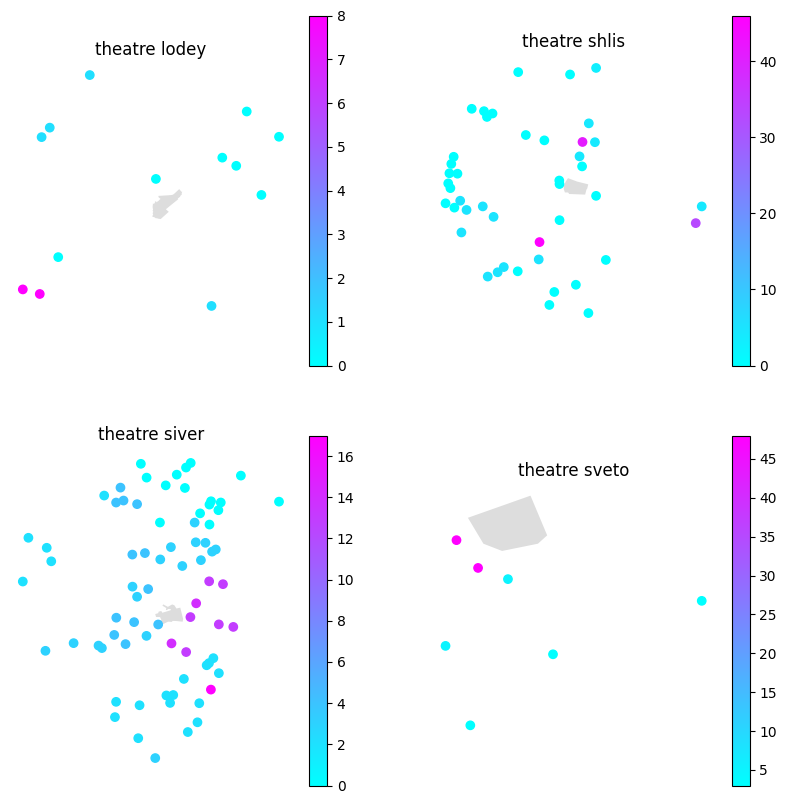

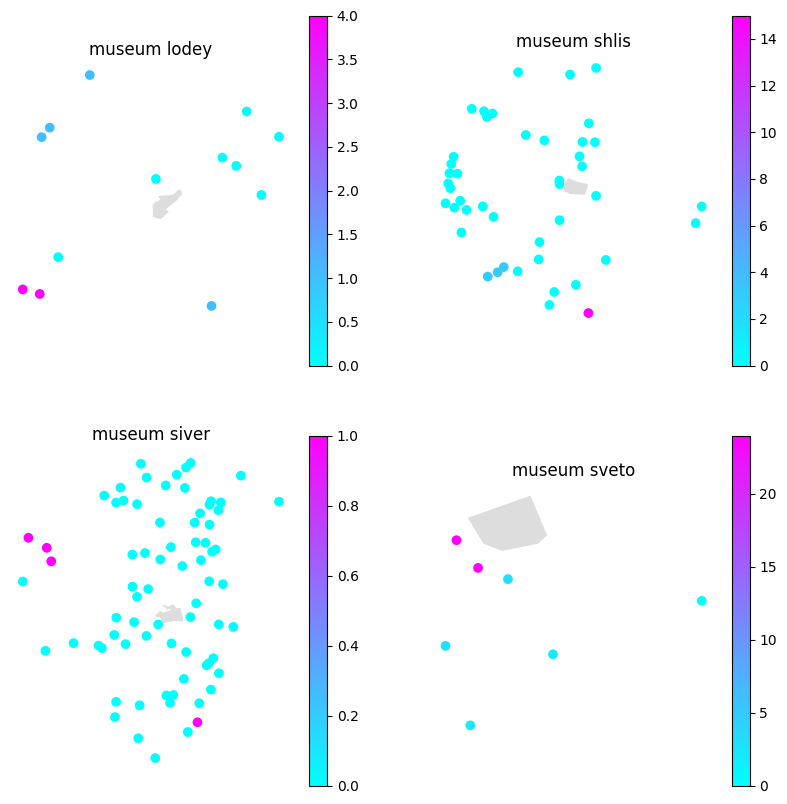

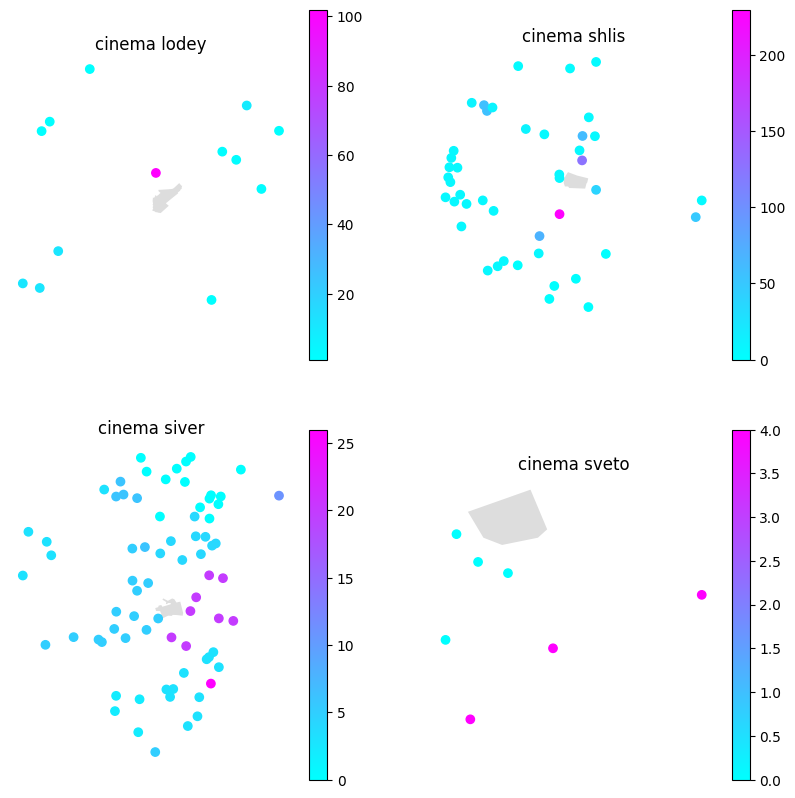

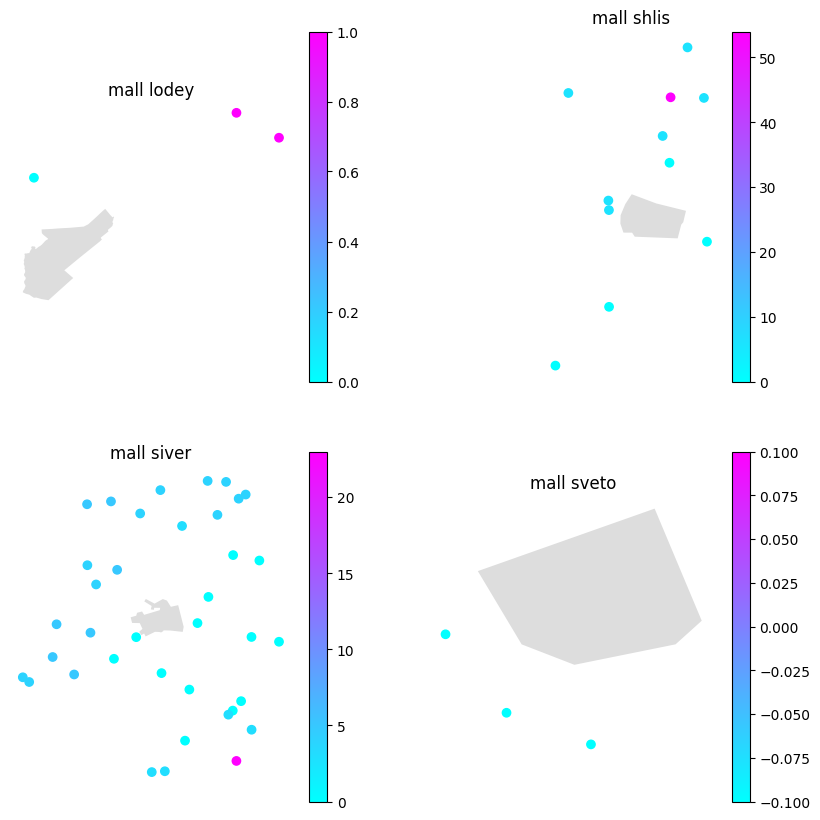

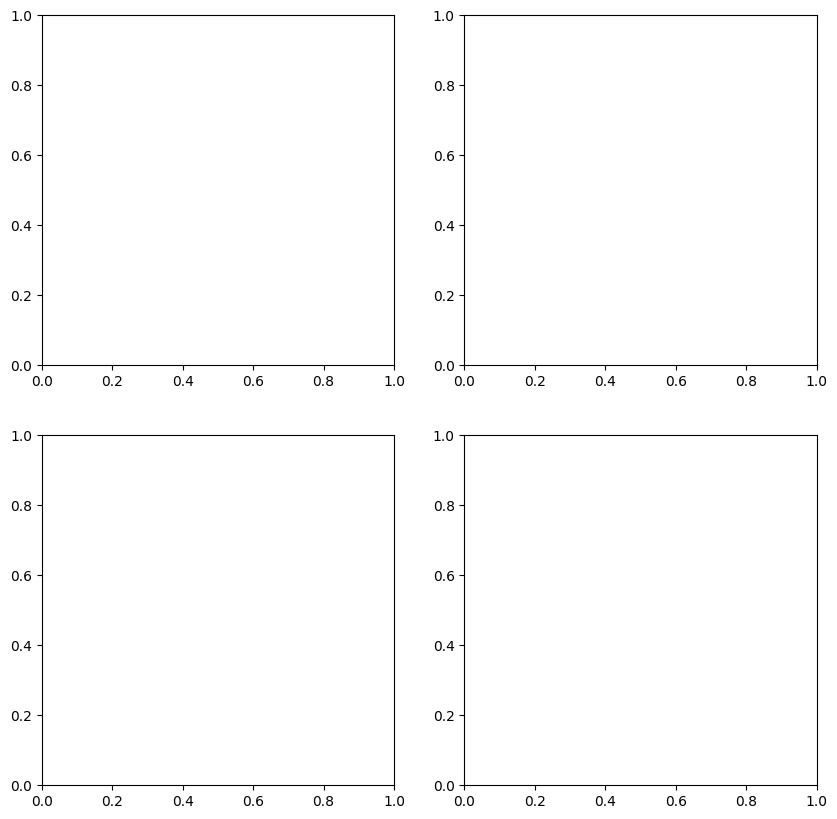

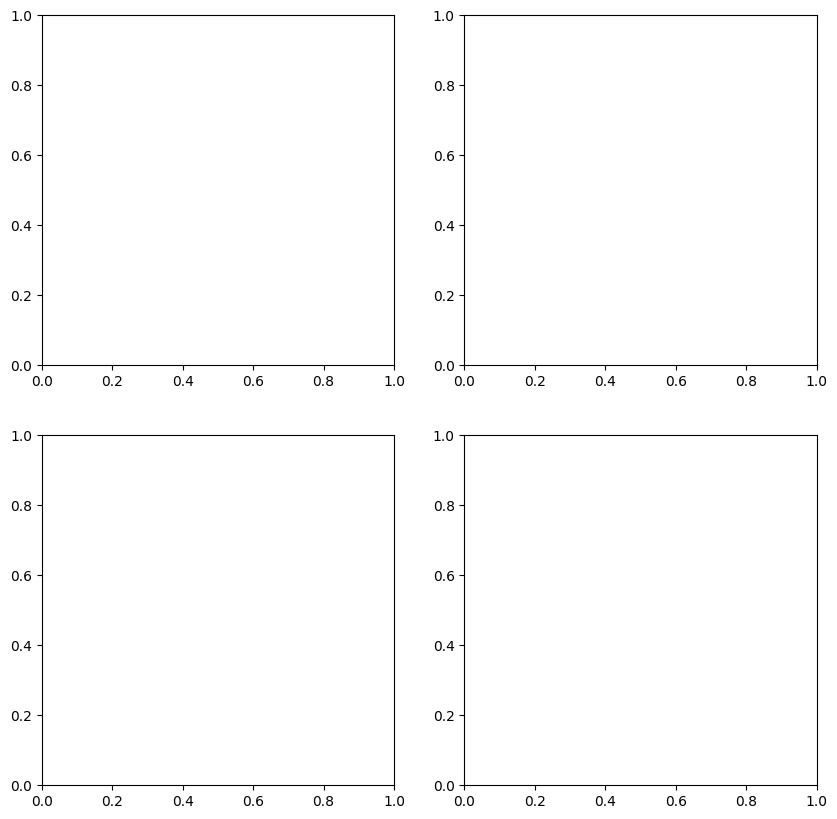

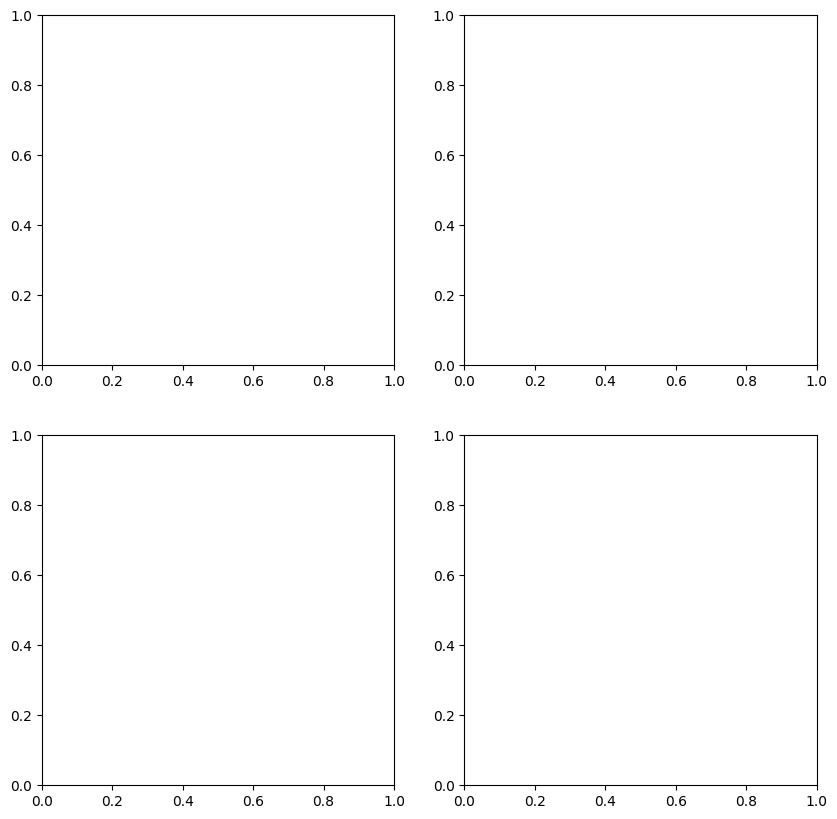

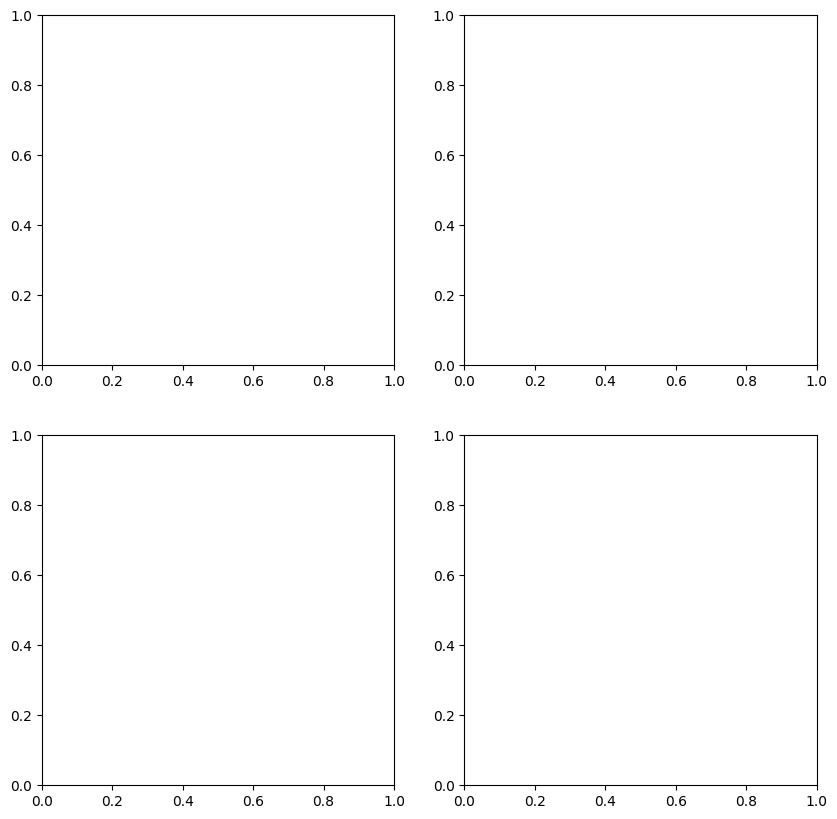

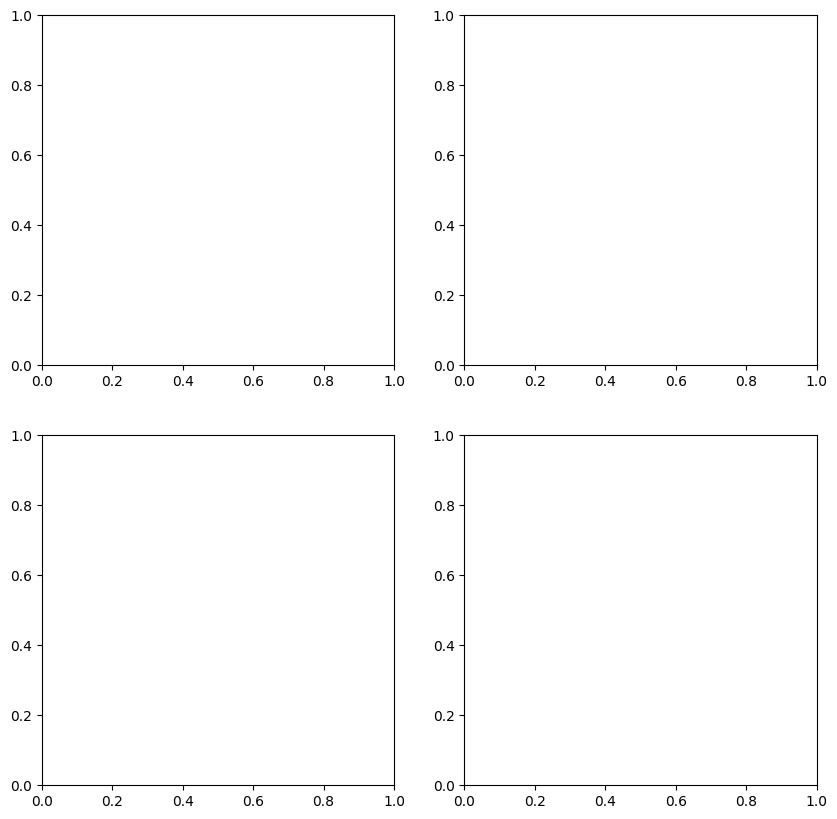

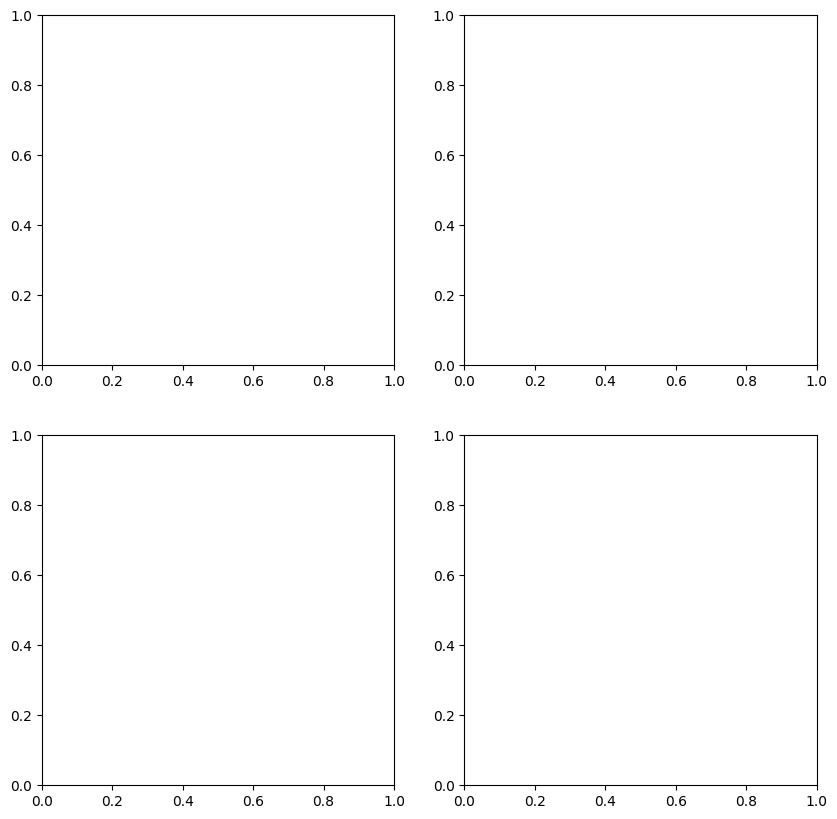

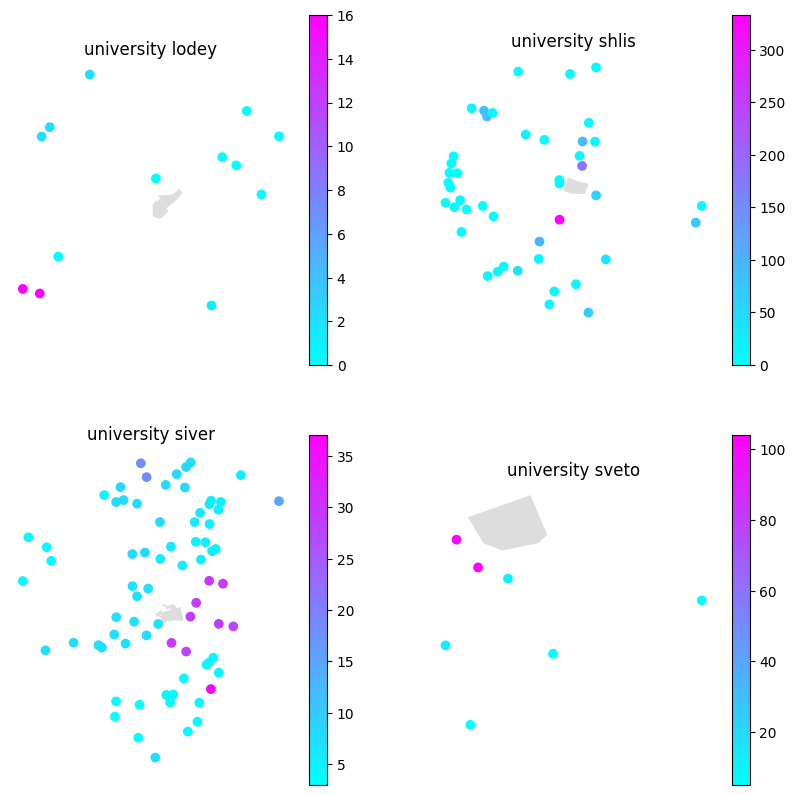

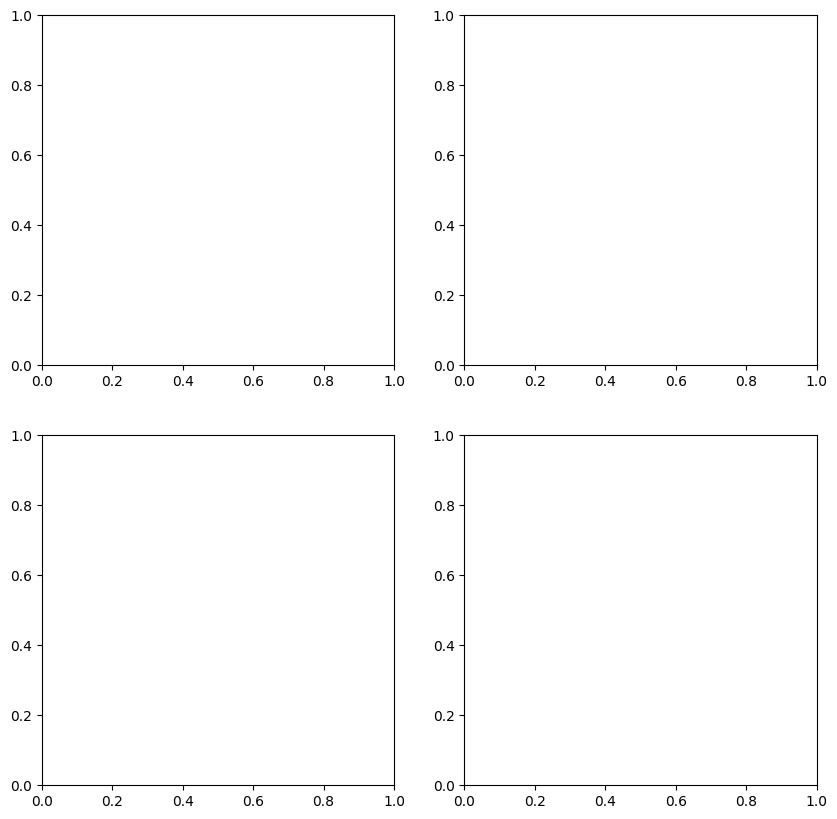

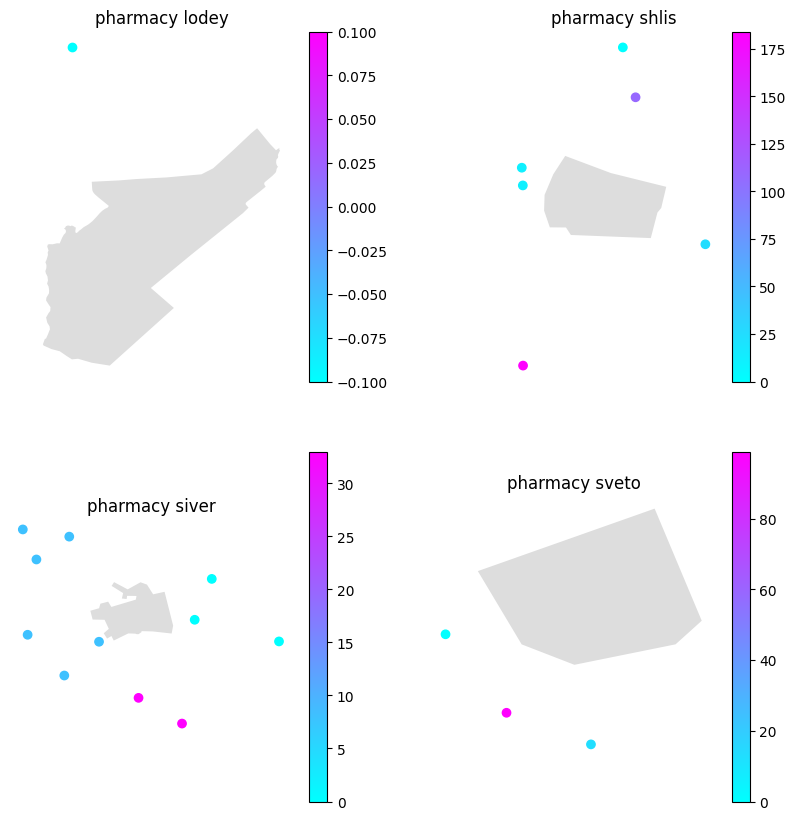

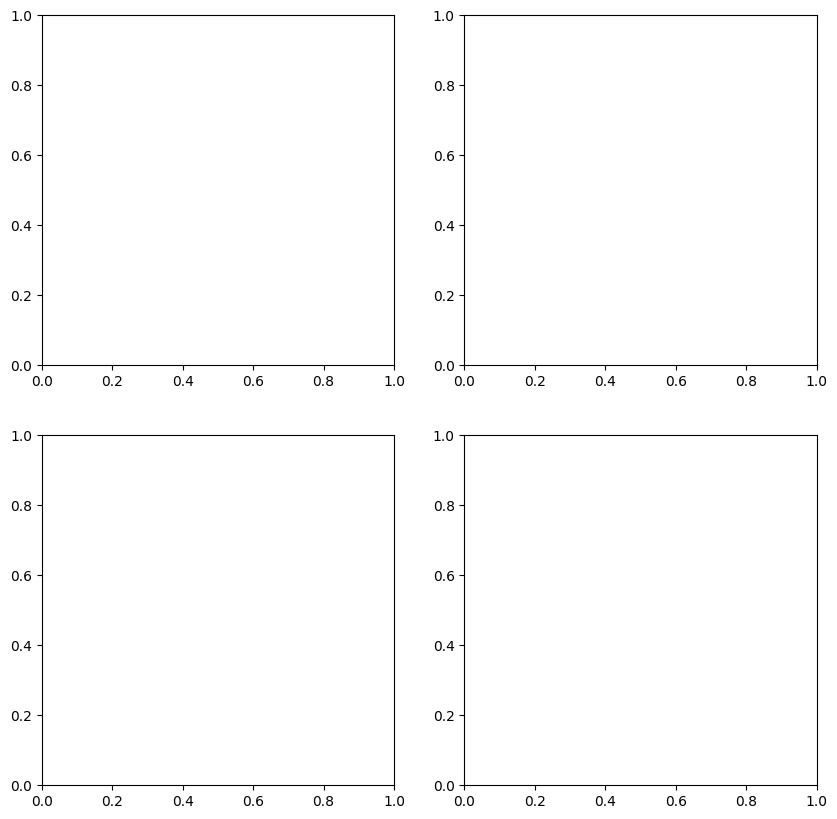

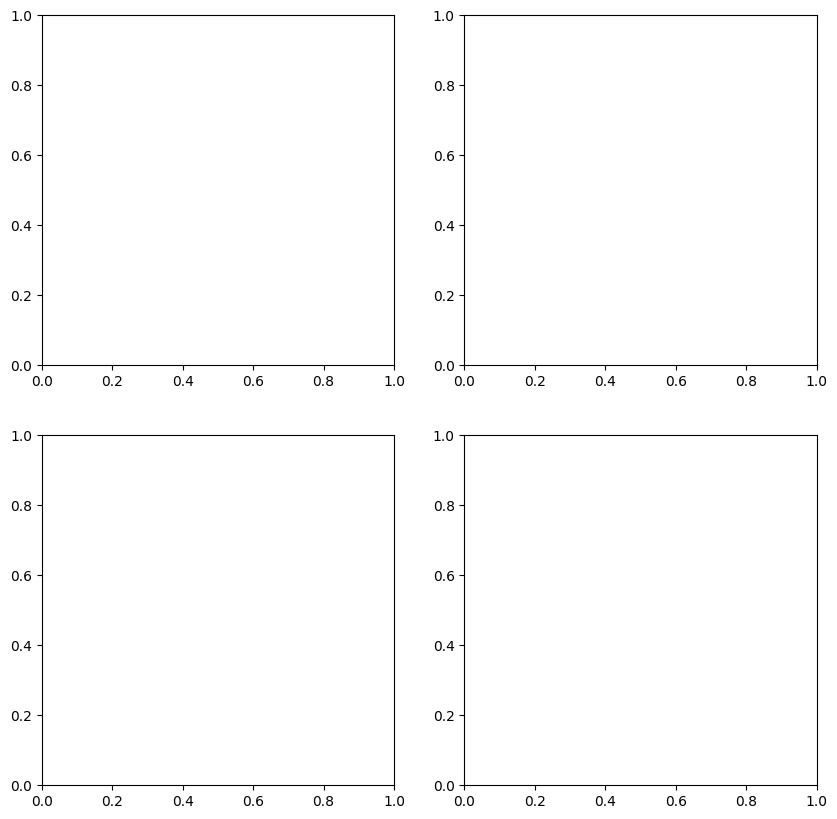

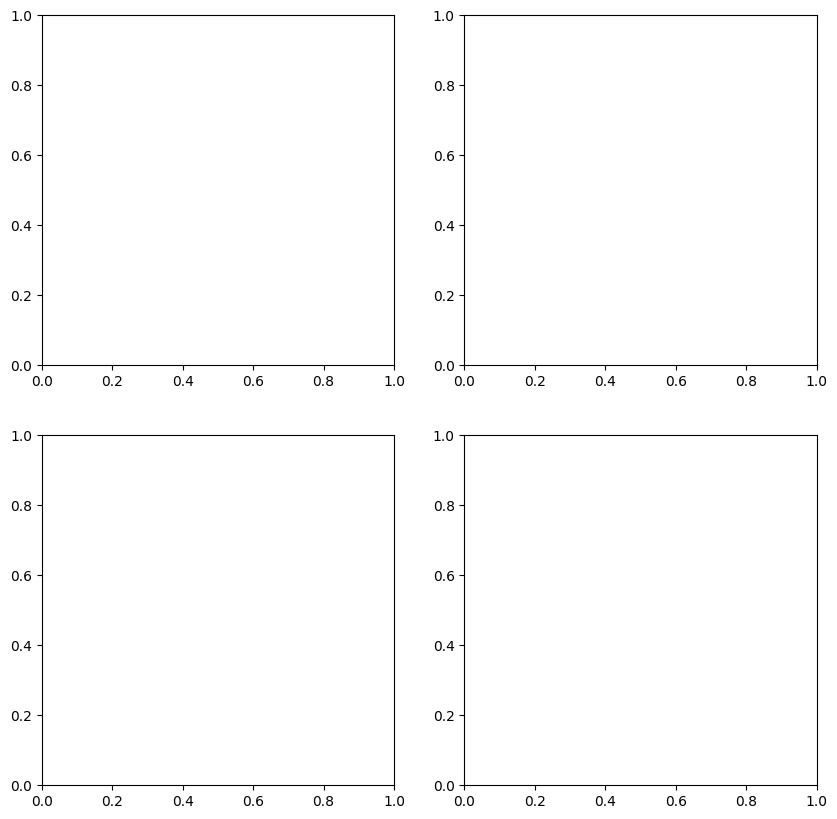

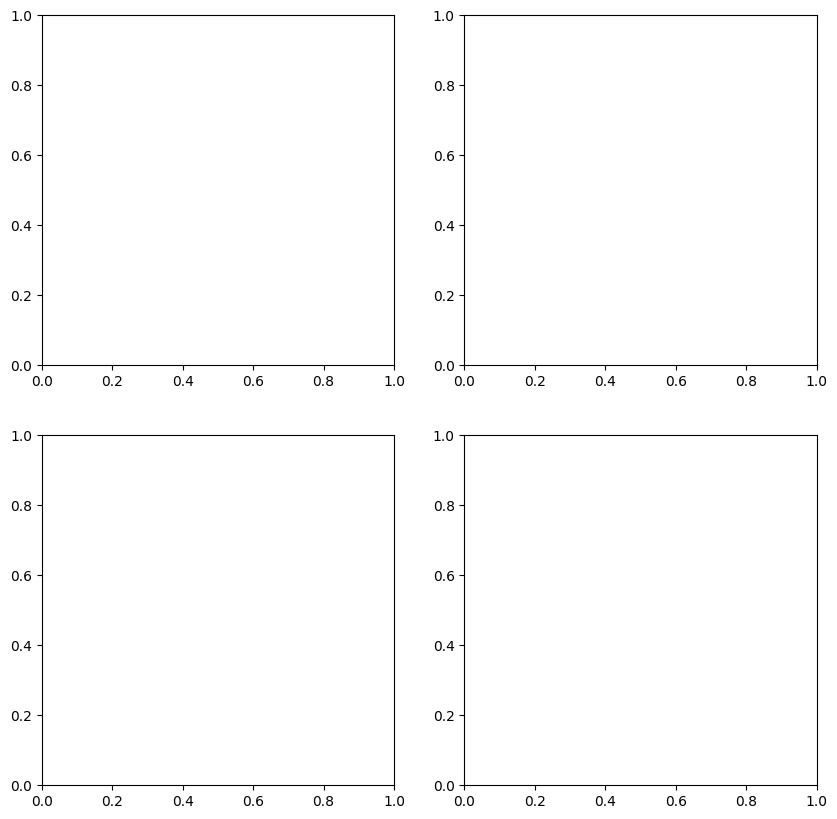

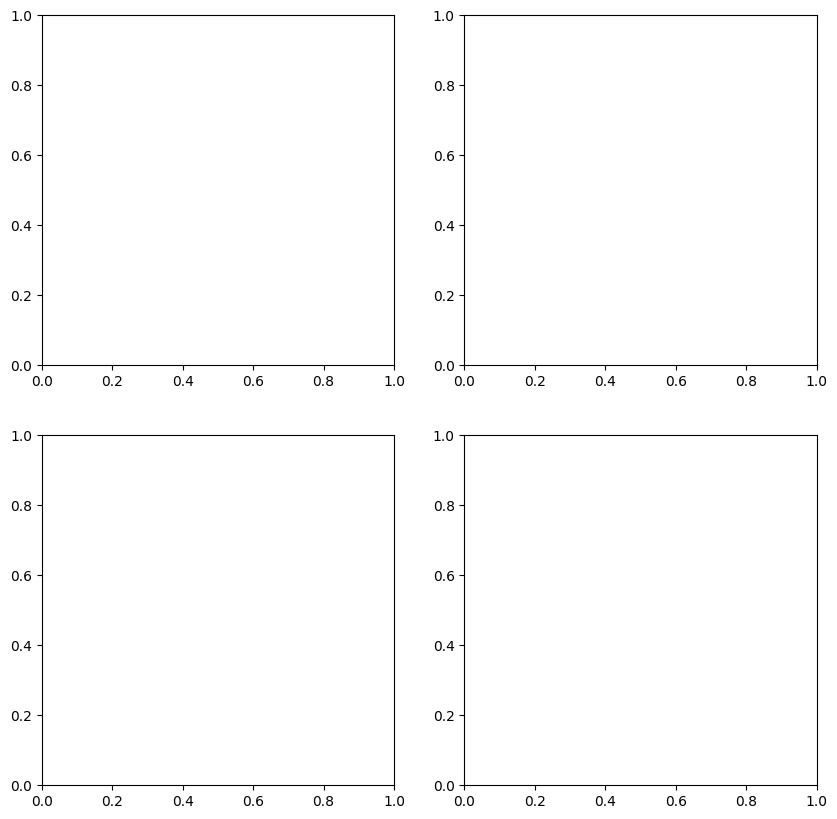

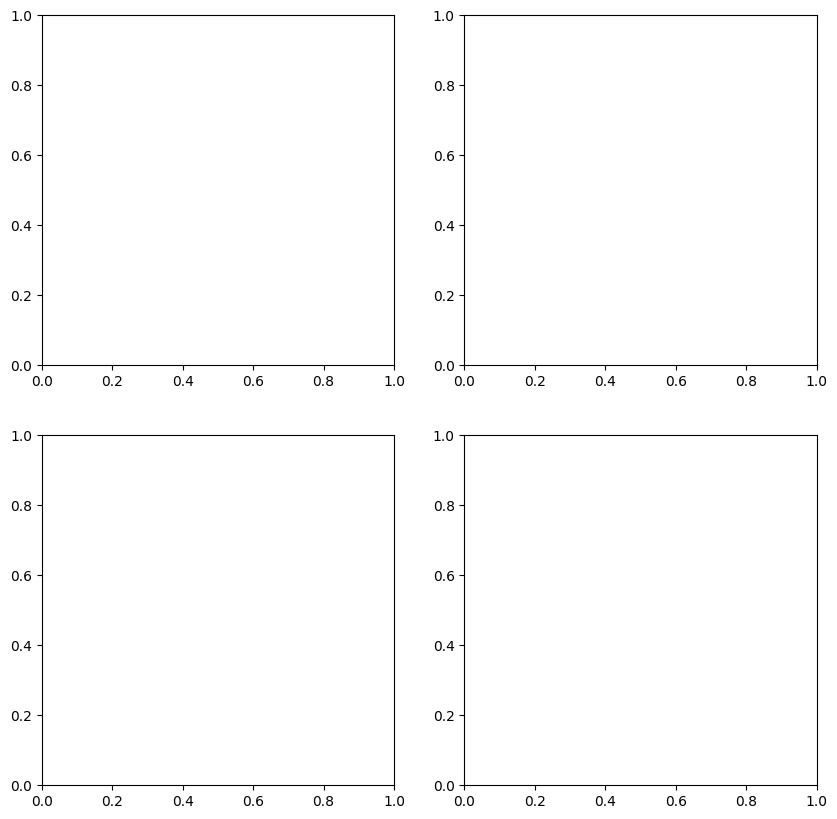

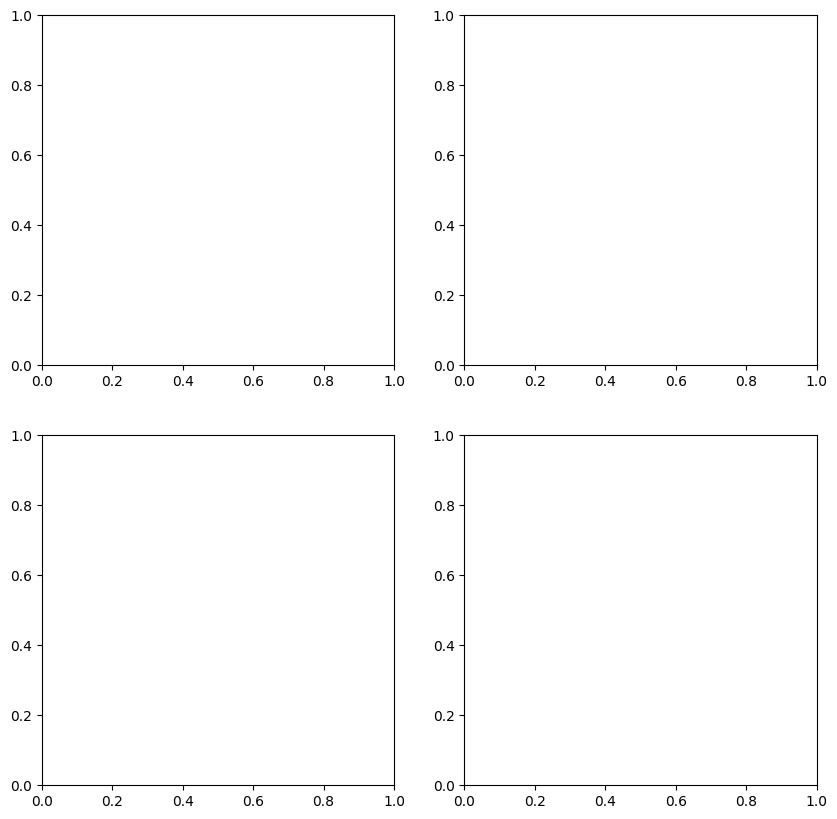

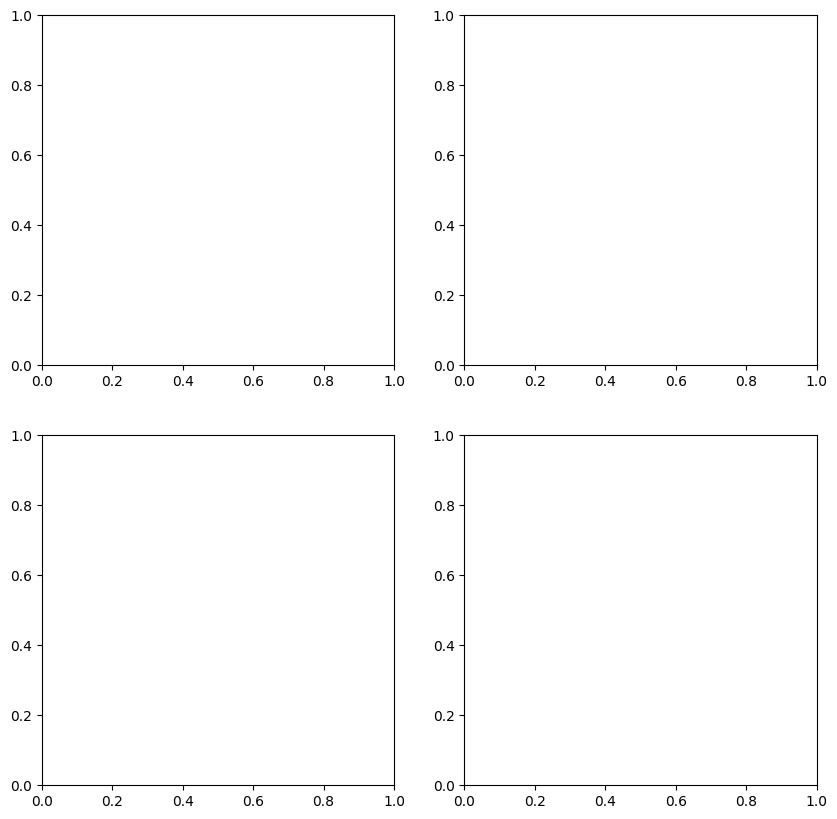

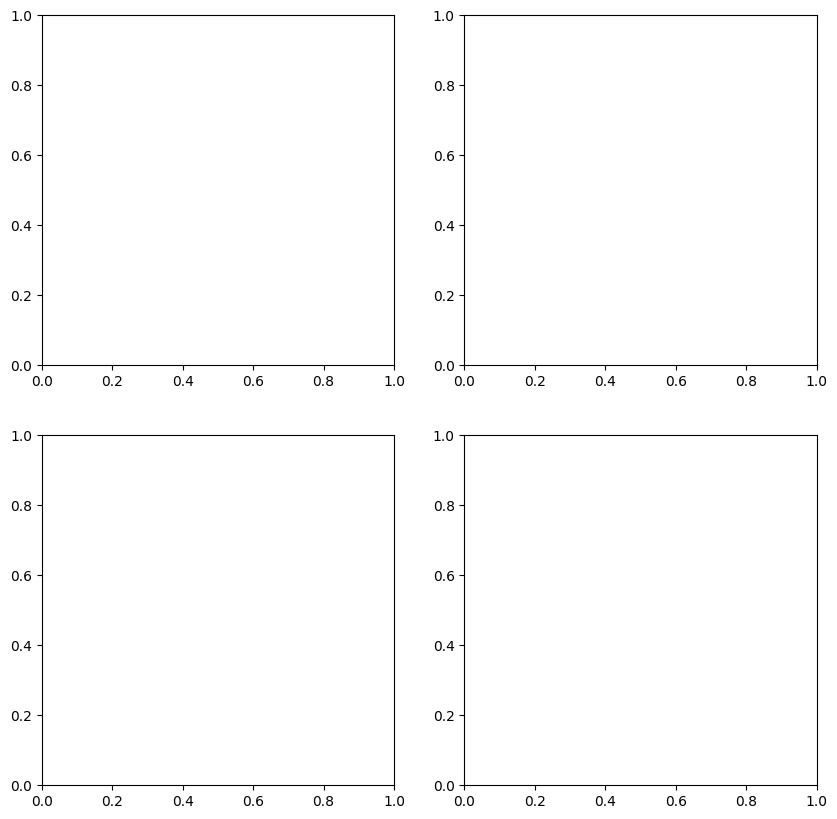

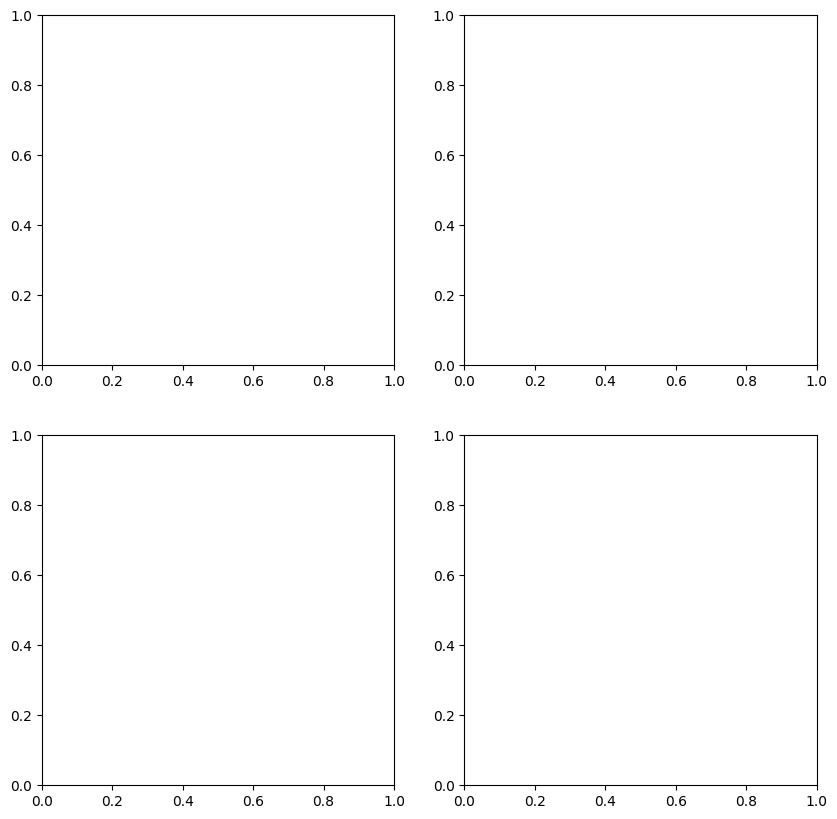

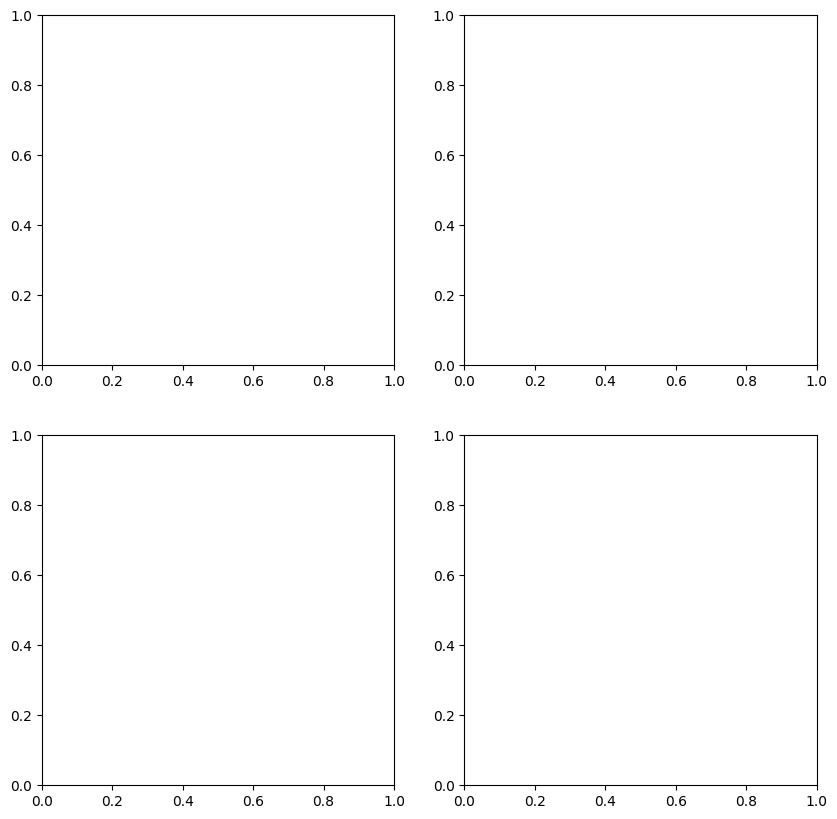

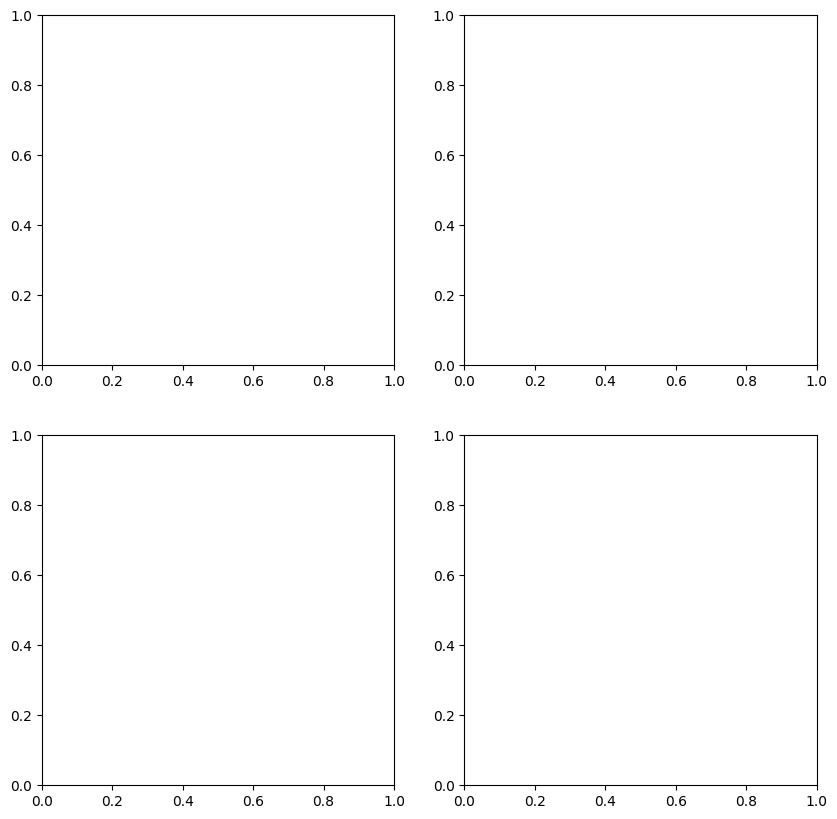

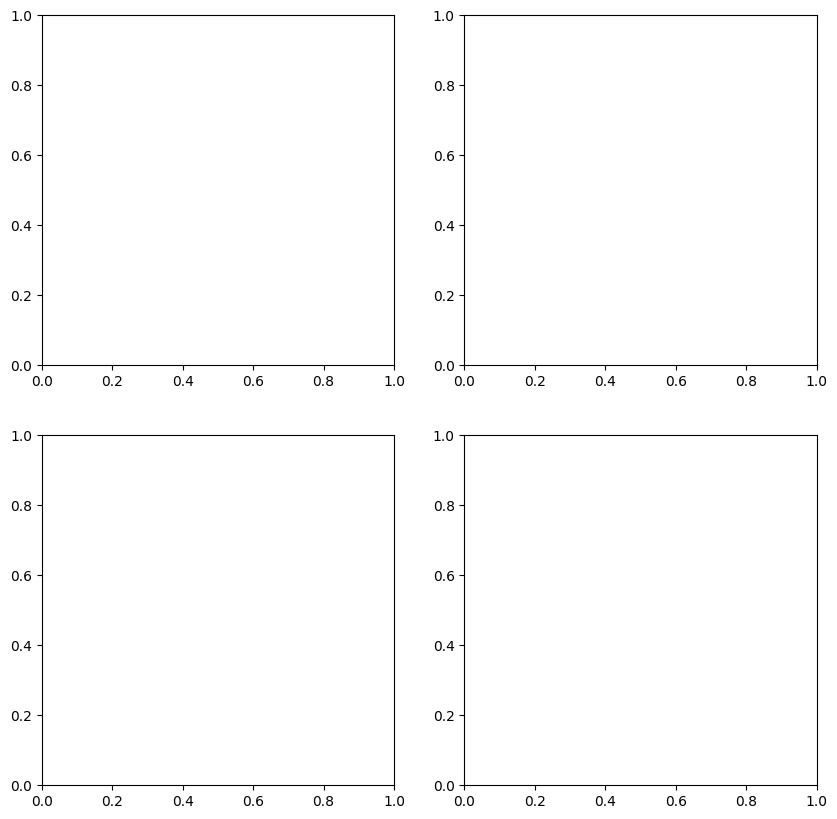

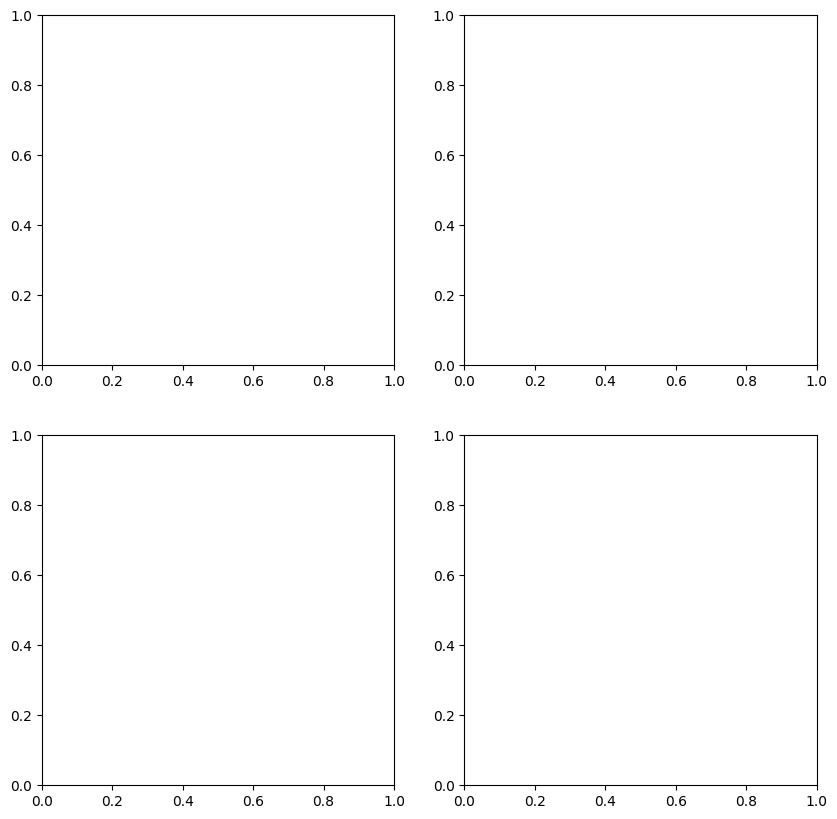

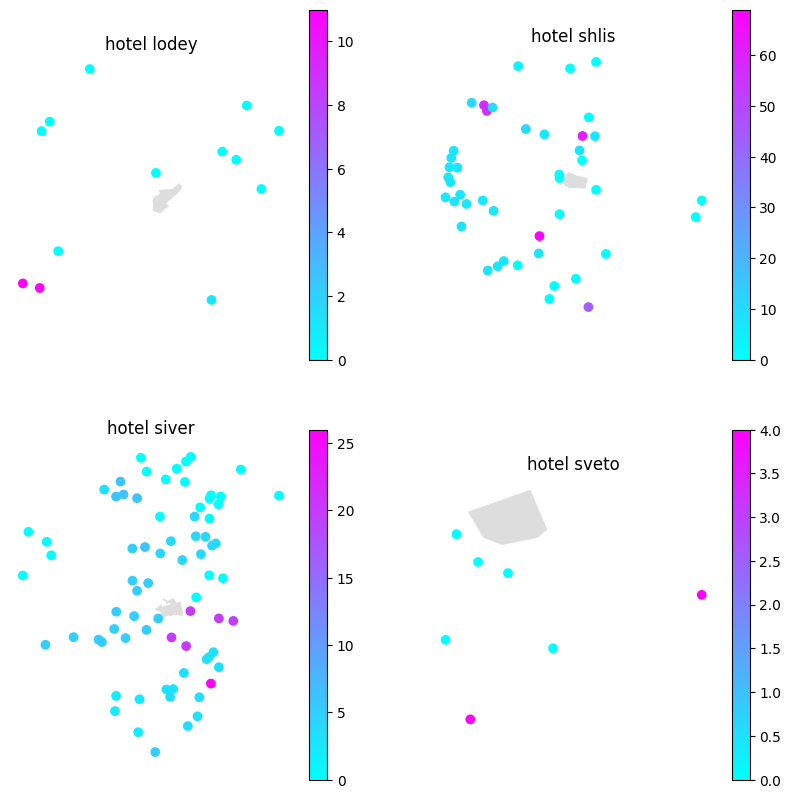

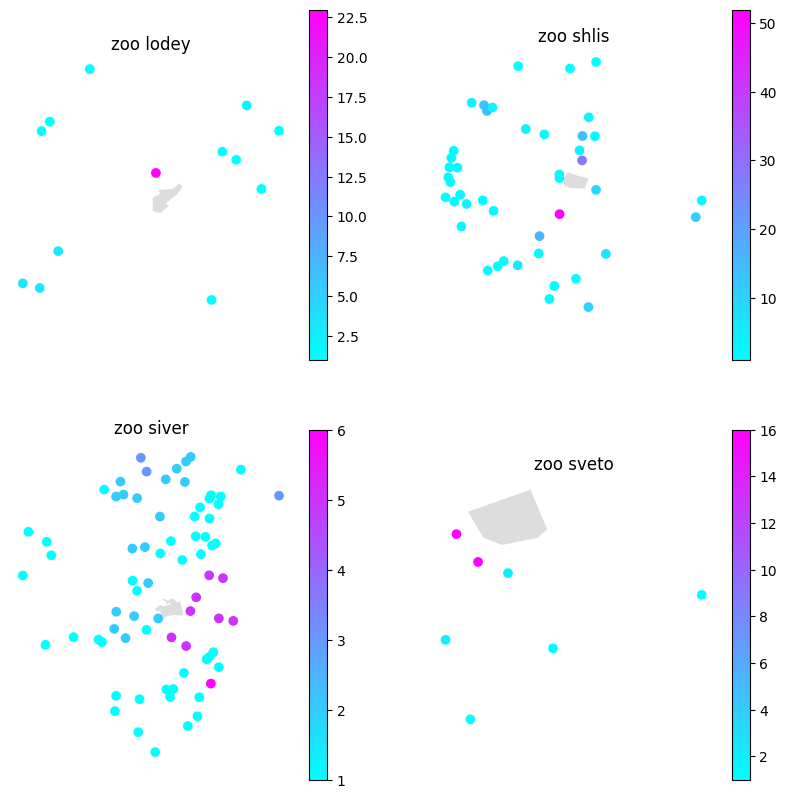

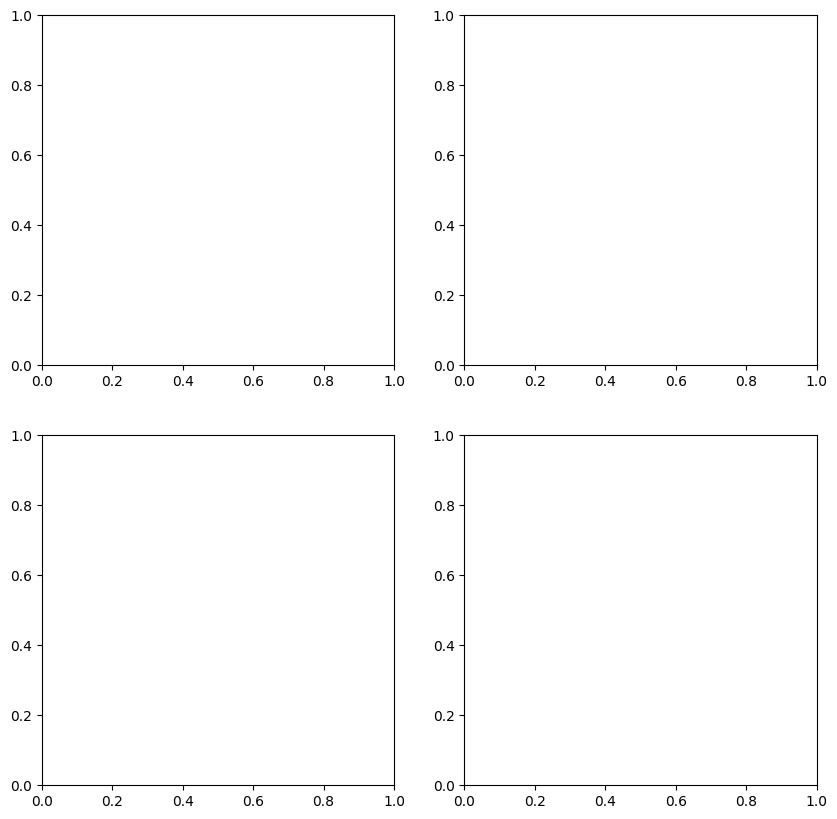

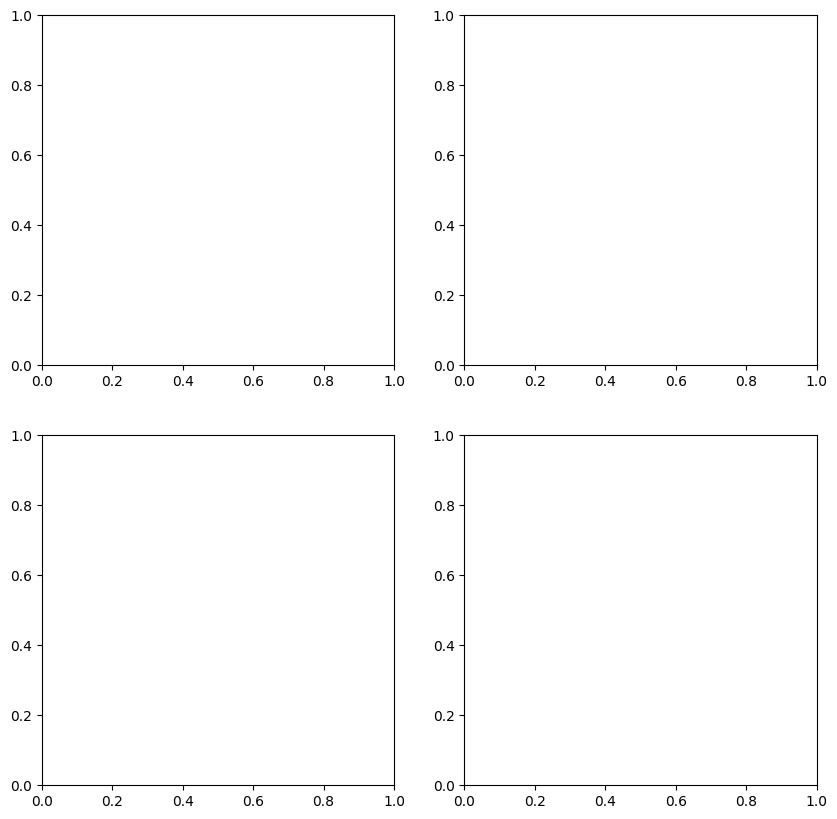

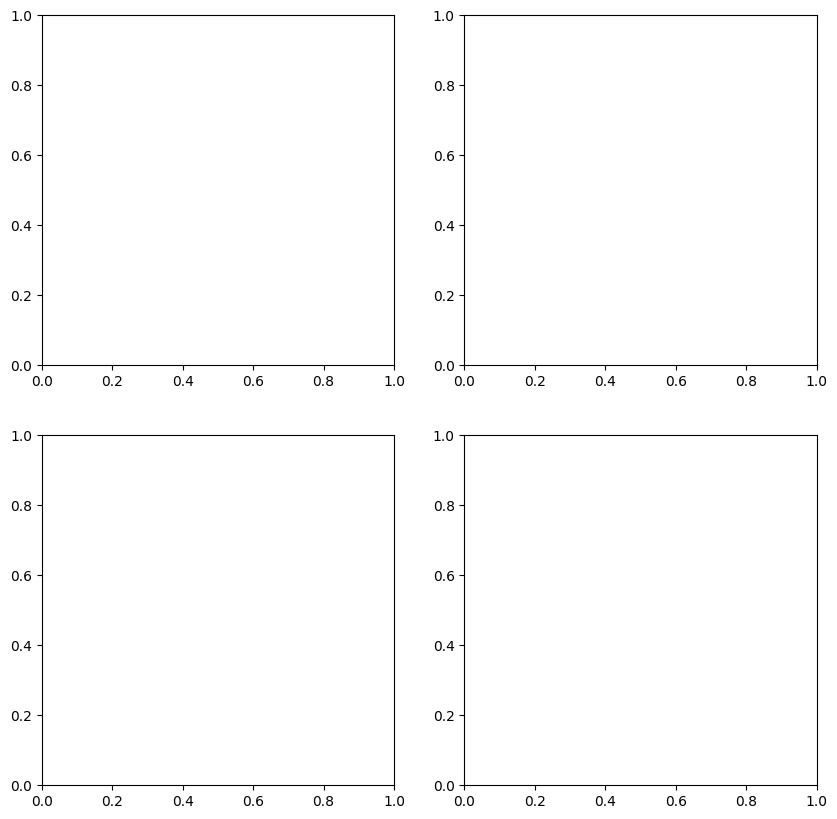

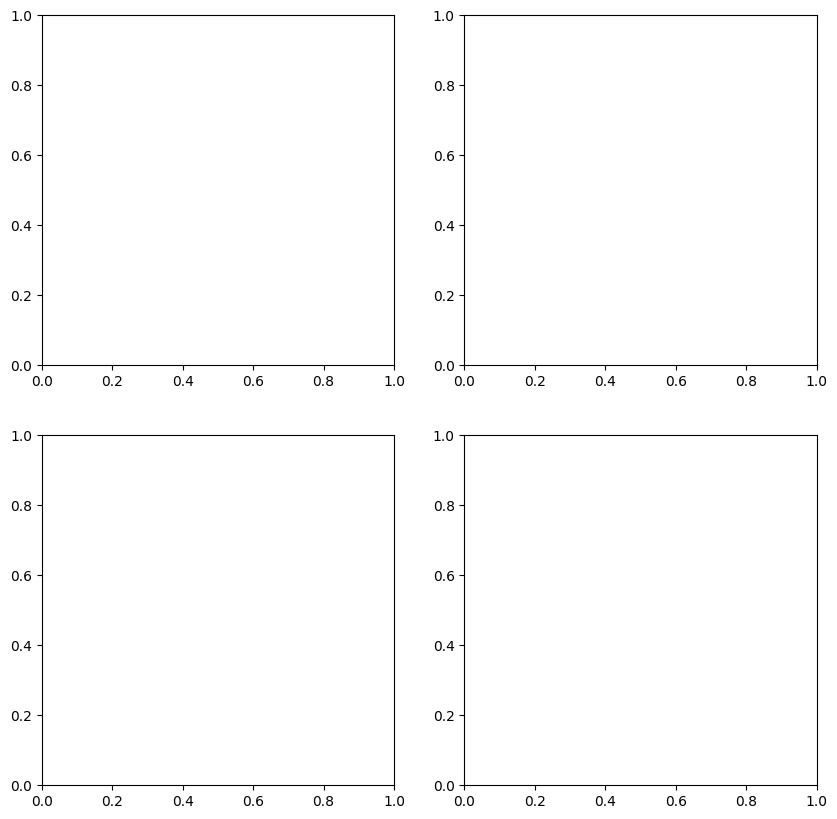

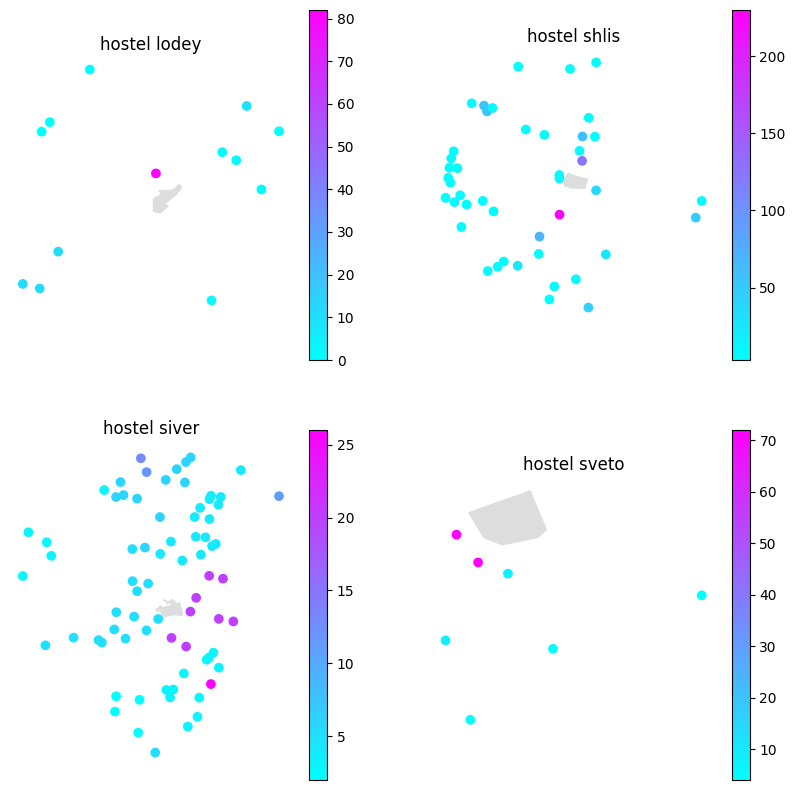

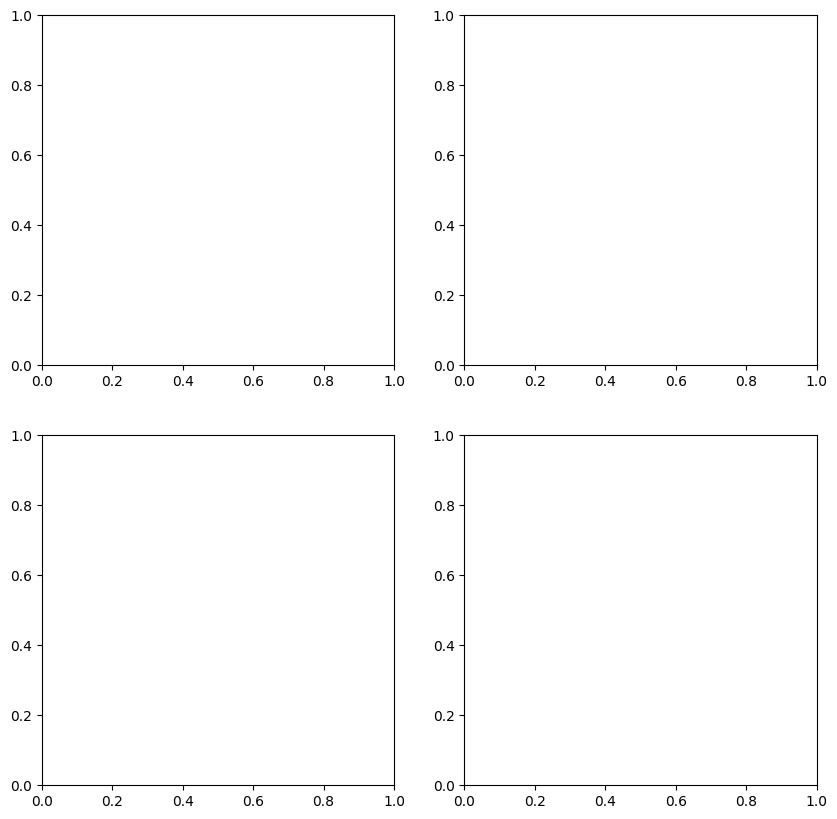

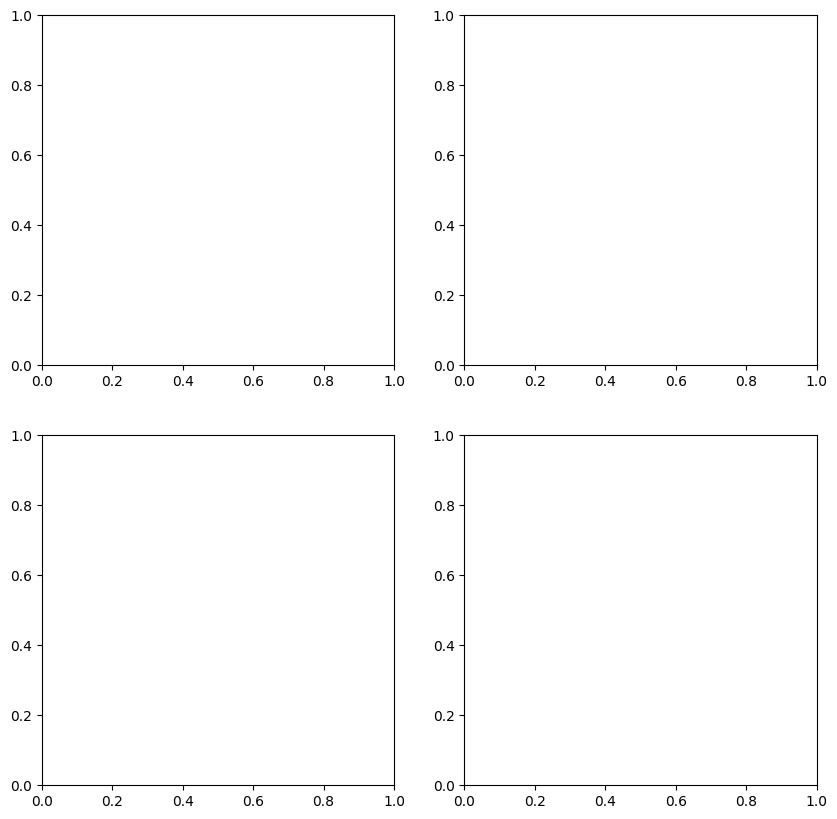

In [177]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

for service_type in service_types:
  fig = plt.figure(figsize=(10,10))
  grid = GridSpec(2,2)
  axes = {
    'lodey': fig.add_subplot(grid[0,0]),
    'shlis': fig.add_subplot(grid[0,1]),
    'siver': fig.add_subplot(grid[1,0]),
    'sveto': fig.add_subplot(grid[1,1]) 
  }
  for territory_name in territories.keys():
    try :
      sjoin = sjoins[territory_name][service_type]
      sjoin['demand_potential'] = sjoin['demand_left'] + sjoin['demand_without']
      ax = axes[territory_name]
      ax.set_title(f'{service_type} {territory_name}')
      sjoin.plot(ax = ax, column='demand_potential', cmap='cool', legend=True)
      territories[territory_name].plot(ax=ax, color='#ddd', zorder=0)
      ax.set_axis_off()
    except:
      ...

In [121]:
import pandas as pd

columns=[
  'demand',
  'demand_left',
  'demand_within',
  'demand_without',
  'capacity',
  'capacity_left'
]

result = {}
for territory_name in sjoins.keys():
  rows = []
  for service_type in sjoins[territory_name].keys():
    row = {'service_type': service_type}
    for column in columns:
      row[column] = sjoins[territory_name][service_type][column].sum()
    rows.append(row)
  df = pd.DataFrame(rows).set_index('service_type')
  df['demand_potential'] = df['demand_left'] + df['demand_without']
  result[territory_name] = df

<Axes: title={'center': 'Аэродром Лодейное Поле'}, xlabel='service_type'>

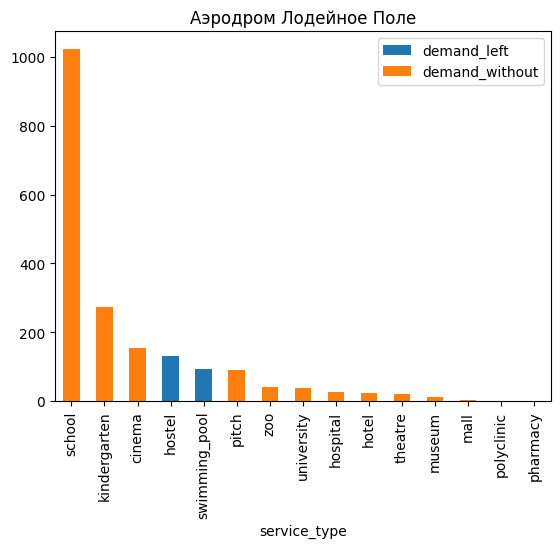

In [186]:
result['lodey'].sort_values('demand_potential', ascending=False).plot(y=['demand_left', 'demand_without'], stacked=True, kind='bar', title='Аэродром Лодейное Поле')

<Axes: title={'center': 'Шлиссельбургское городское поселение'}, xlabel='service_type'>

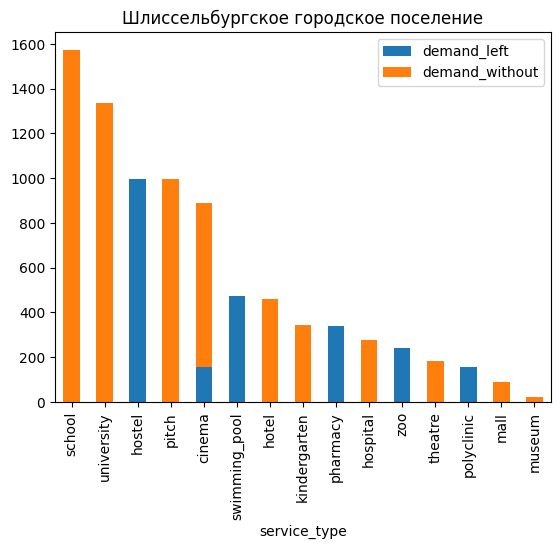

In [187]:
result['shlis'].sort_values('demand_potential', ascending=False).plot(y=['demand_left', 'demand_without'], stacked=True, kind='bar', title='Шлиссельбургское городское поселение')

<Axes: title={'center': 'Аэродром Сиверский'}, xlabel='service_type'>

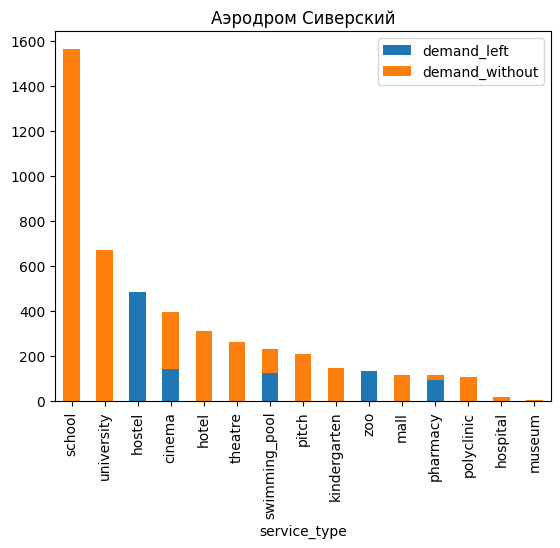

In [188]:
result['siver'].sort_values('demand_potential', ascending=False).plot(y=['demand_left', 'demand_without'], stacked=True, kind='bar', title='Аэродром Сиверский')

<Axes: title={'center': 'Светогорское городское поселение'}, xlabel='service_type'>

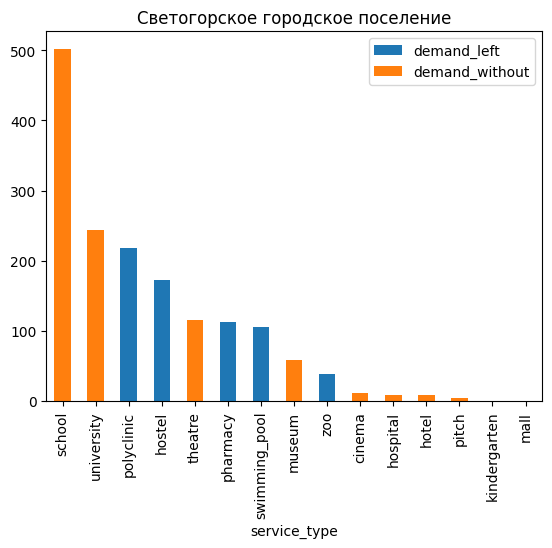

In [189]:
result['sveto'].sort_values('demand_potential', ascending=False).plot(y=['demand_left', 'demand_without'], stacked=True, kind='bar', title='Светогорское городское поселение')